## Performance Metrics

### Step 1: Importing all the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import warnings
import math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")

### Step 2: Importing the input data

In [ ]:
df_perf_model_1 = pd.read_csv("C:\\Users\\DeepakArun\\Documents\\Desktop\\Robyn_202407301323_init\\pareto_aggregated.csv")
df_pred_model_1 = pd.read_csv("C:\\Users\\DeepakArun\\Documents\\Desktop\\Robyn_202407301323_init\\pareto_alldecomp_matrix.csv")
df_spend = pd.read_csv("C:\\Users\\DeepakArun\\Documents\\Desktop\\Robyn_202407301323_init\\pareto_media_transform_matrix.csv")
df_target = df_pred_model_1.copy()


### Step 3: Creating functions for MAPE and SMAPE calculation

In [ ]:
def mape(actual, pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
    - actual (array-like): Actual values.
    - pred (array-like): Predicted values.

    Returns:
    - MAPE (float): The mean absolute percentage error.
    """
    return np.mean(abs(actual - pred) / actual)


def smape(actual, pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).

    Parameters:
    - actual (array-like): Actual values.
    - pred (array-like): Predicted values.

    Returns:
    - SMAPE (float): The symmetric mean absolute percentage error.
    """
    smape = abs(actual - pred) / (actual + pred)
    smape = np.mean(smape[~smape.isna()])  # Exclude NaN values
    return smape


def calculate_mape_smape(metric, actual_, pred_, train_size, val_size, test_size):
    """
    Calculate MAPE or SMAPE for train, validation, and test splits.

    Parameters:
    - metric (str): The metric to calculate ('MAPE' or 'SMAPE').
    - actual_ (array-like): Actual values.
    - pred_ (array-like): Predicted values.
    - train_size (int): Size of the training set.
    - val_size (int): Size of the validation set.
    - test_size (int): Size of the test set.

    Returns:
    - result (list): List of MAPE/SMAPE values for train, validation, and test sets.
    """
    result = []

    for split in ['train', 'val', 'test']:
        if split == 'train':
            actual = actual_[0:train_size]
            pred = pred_[0:train_size]
        elif split == 'val':
            actual = actual_[train_size:val_size + train_size]
            pred = pred_[train_size:val_size + train_size]
        else:  # 'test'
            actual = actual_[val_size + train_size:val_size + train_size + test_size]
            pred = pred_[val_size + train_size:val_size + train_size + test_size]

        # Calculate the metric (MAPE or SMAPE)
        if metric == 'MAPE':
            result.append(mape(actual, pred))
        else:
            result.append(smape(actual, pred))

    return result




### Step 4: Preparing the model performance summary 

This function Summarizes model performance by calculating various metrics, including R-squared,NRMSE, MAPE, and SMAPE for train, validation, and test sets then returns a DataFrame summarizing the performance metrics.

In [ ]:
def model_performance_summary(df_perf, df_actual_vs_fitted, model_id=None):
    """
    Summarizes model performance by calculating various metrics, including R-squared,
    NRMSE, MAPE, and SMAPE for train, validation, and test sets.

    Parameters:
    - df_perf (DataFrame): DataFrame containing performance metrics for models.
    - df_actual_vs_fitted (DataFrame): DataFrame with actual vs. predicted values.
    - model_id (str or None): Specific model ID to summarize. If None, all models are summarized.

    Returns:
    - model_performance_summary (DataFrame): A DataFrame summarizing the performance metrics.
    """
    # If no model ID is provided, use all unique model IDs
    if model_id is None:
        model_itr_list = list(df_perf['solID'].unique())
    else:
        model_itr_list = [model_id]

    # Initialize an empty DataFrame for output
    model_performance_summary = pd.DataFrame(columns=[
        'solID', 'rn', 'spend_share', 'effect_share', 'coef', 'coef_rank',
        'xDecompMeanNon0Perc', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse_train',
        'nrmse_val', 'nrmse_test', 'decomp.rssd', 'mape', 'mape_train', 'mape_val',
        'mape_test', 'smape_train', 'smape_val', 'smape_test', 'top_sol'
    ])

    # List of variables to retain from df_perf
    var_list = [
        'rn', 'coef', 'xDecompMeanNon0Perc', 'rsq_train', 'rsq_val', 'rsq_test',
        'nrmse_train', 'nrmse_val', 'nrmse_test', 'decomp.rssd', 'mape', 'solID',
        'spend_share', 'effect_share', 'top_sol'
    ]

    # Iterate through each model ID in the list
    for model_id in model_itr_list:
        # Filter data for the current model ID
        df_perf_temp = df_perf[df_perf['solID'] == model_id].reset_index(drop=True)
        df_actual_vs_fitted_temp = df_actual_vs_fitted[df_actual_vs_fitted['solID'] == model_id].reset_index(drop=True)

        # Calculate sizes for train, validation, and test splits
        train_size = round(df_perf_temp['train_size'][0] * df_actual_vs_fitted_temp.shape[0])
        val_size = round((df_actual_vs_fitted_temp.shape[0] - train_size) / 2)
        test_size = round(df_actual_vs_fitted_temp.shape[0] - train_size - val_size)

        # Subset df_perf_temp with the relevant variables
        df_perf_temp = df_perf_temp[var_list]

        # Rank coefficients
        df_perf_temp['coef_rank'] = df_perf_temp['coef'].rank(ascending=False, method='dense')

        # Calculate MAPE for train, validation, and test sets
        mape_res = calculate_mape_smape('MAPE', df_actual_vs_fitted_temp['dep_var'], df_actual_vs_fitted_temp['depVarHat'], train_size, val_size, test_size)
        df_perf_temp['mape_train'] = mape_res[0]
        df_perf_temp['mape_val'] = mape_res[1]
        df_perf_temp['mape_test'] = mape_res[2]

        # Calculate SMAPE for train, validation, and test sets
        smape_res = calculate_mape_smape('SMAPE', df_actual_vs_fitted_temp['dep_var'], df_actual_vs_fitted_temp['depVarHat'], train_size, val_size, test_size)
        df_perf_temp['smape_train'] = smape_res[0]
        df_perf_temp['smape_val'] = smape_res[1]
        df_perf_temp['smape_test'] = smape_res[2]

        # Concatenate the result to the output DataFrame
        model_performance_summary = pd.concat([model_performance_summary, df_perf_temp])

    return model_performance_summary


### Step 5: Calling the Model Performance Summary Function

In [ ]:
model_performance_summary = model_performance_summary(df_perf_model_1, df_pred_model_1)
model_performance_summary

## Response Curve

### Step 6: Preparing the data for Respose Curve Generation

This function prepares the response curve data by merging spend and target data for each channel and produces a DataFrame with combined spend and target data for each channel.

In [ ]:
def prepare_response_curve_data(modelID, df_spend, df_target):
    """
    Prepares the response curve data by merging spend and target data for each channel.

    Parameters:
    - modelID: The specific model identifier to filter data.
    - df_spend: DataFrame containing spend data.
    - df_target: DataFrame containing target response data.

    Returns:
    - df_response_curve: DataFrame with combined spend and target data for each channel.
    """
    df_spend = df_spend[df_spend['solID'] == modelID]
    df_spend = df_spend[df_spend['type'] == 'saturatedSpendReversed']
    df_target = df_target[df_target['solID'] == modelID]

    subset = [cols for cols in list(df_spend.columns) if 'spend' in cols.lower()]

    df_response_curve = pd.DataFrame(columns=['channel', 'date', 'spend_total', 'target_total'])

    for cols in subset:
        df_spend_temp = df_spend[['ds', cols]].rename({'ds': 'date', cols: 'spend_total'}, axis=1)
        df_target_temp = df_target[['ds', cols]].rename({'ds': 'date', cols: 'target_total'}, axis=1)

        df_temp = pd.merge(df_spend_temp, df_target_temp, on='date')
        df_temp['channel'] = cols
        df_response_curve = pd.concat([df_response_curve, df_temp])

    return df_response_curve


### Step 7: Setting the Model Id and calling the response curve function

In [ ]:
# Set modelID to filter
modelID = '1_1550_2'

# Call the function
df_response_curve = prepare_response_curve_data(modelID, df_spend, df_target)

### Step 8: Preparing for generating overall response curve

This function Generates a combined response curve plot for multiple channels

In [ ]:
def millions_formatter(x, pos):
    """Formats axis values in millions."""
    return f'{x / 1e6:.1f}M'


def thousands_formatter(x, pos):
    """Formats axis values in thousands."""
    return f'{x / 1e3:.0f}k'


def overall_response_curve(model_df, spend_chart_limit=None, target_chart_limit=None):
    """
    Generates a combined response curve plot for multiple channels.

    Parameters:
    - model_df: DataFrame containing response curve values.
    - spend_chart_limit: Optional limit for x-axis (spend).
    - target_chart_limit: Optional limit for y-axis (target response).
    """
    color_list = [
        '#702963', '#0E4C92', '#808000', '#FB9AD1', '#3E424B', '#FFBD33',
        '#00A9FF', '#65451F', '#e6194B', '#469990', '#f58231', '#000000'
    ]
    channel_itr = [
        'Brand_Spend', 'Preload_Digital_Turbine_Spend', 'Preload_IronSource_Aura_Spend',
        'Programmatic_Bidease_Spend', 'Programmatic_IronSource_Sonic_Spend',
        'Programmatic_LiftOff_Spend', 'Programmatic_Persona.ly_Spend', 'Programmatic_Tapjoy_Spend',
        'SEM_Apple_Search_Ads_Spend', 'SEM_Google_Spend', 'Twitter_TikTok_Combined_Spend', 'Influencer_Spend'
    ]
    channel_list = [
        'Brand', 'Preload Digital Turbine', 'Preload IronSource Aura', 'Programmatic Bidease',
        'Programmatic IronSource Sonic', 'Programmatic LiftOff', 'Programmatic Persona.ly', 'Programmatic Tapjoy',
        'SEM Apple Search Ads', 'SEM Google', 'Twitter & TikTok Combined', 'Influencer Spend'
    ]

    print("*** Generating Response Curve for channels: ***")

    model_df_ = model_df.copy()
    if spend_chart_limit is not None:
        model_df_ = model_df_[model_df_['spend_total'] <= spend_chart_limit]
    if target_chart_limit is not None:
        model_df_ = model_df_[model_df_['target_total'] <= target_chart_limit]

    counter = 0
    for ch in channel_itr:
        print(channel_list[counter])
        df_temp = model_df_[model_df_['channel'] == ch].reset_index().sort_values('spend_total')

        avg_spend = df_temp['spend_total'].mean()
        closest_point = df_temp.iloc[(df_temp['spend_total'] - avg_spend).abs().argsort()[:1]]

        sns.lineplot(
            data=df_temp, x='spend_total', y='target_total', label=channel_list[counter],
            color=color_list[counter]
        )
    # Uncomment the following lines to plot the Avg Spend in the response curves    
        #plt.scatter(
        #    closest_point['spend_total'], closest_point['target_total'], marker='o',
        #    color=color_list[counter], s=25, label=f'Avg Spend ({avg_spend:.2f})'
        #)

        plt.gca().yaxis.set_major_formatter(millions_formatter)
        plt.gca().xaxis.set_major_formatter(thousands_formatter)
        counter += 1

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Spend')
    plt.ylabel('Response (Visits)')
    plt.show()



### Step 9: Calling the Overall Response curve function

In [ ]:
# Set the DataFrame for the model
df_overall_response_curve = df_response_curve

# Call the function with optional parameters
overall_response_curve(
    df_overall_response_curve,
    spend_chart_limit=None,
    target_chart_limit=None
)


### Step 10: Preparing for generating individual response curve

This function Generates individual response curves for each channel

In [ ]:

def check_value_scale(value):
    """
    Determines the appropriate scale (millions or thousands) based on the maximum value.

    Parameters:
    - value: Series of values to check.

    Returns:
    - scale: "millions", "thousands", or "unknown".
    """
    max_val = max(value)
    if max_val >= 1_000_000:
        return "millions"
    elif max_val >= 1_000:
        return "thousands"
    else:
        return "unknown"


def individual_response_curve(model_df, spend_chart_limit=None, target_chart_limit=None):
    """
    Generates individual response curves for each channel.

    Parameters:
    - model_df: DataFrame containing response curve values.
    - spend_chart_limit: Optional limit for x-axis (spend).
    - target_chart_limit: Optional limit for y-axis (target response).
    """
    color_list = [
        '#702963', '#0E4C92', '#808000', '#FB9AD1', '#3E424B', '#FFBD33',
        '#00A9FF', '#65451F', '#e6194B', '#469990', '#f58231', "#000000"
    ]
    channel_itr = [
        'Brand_Spend', 'Preload_Digital_Turbine_Spend', 'Preload_IronSource_Aura_Spend',
        'Programmatic_Bidease_Spend', 'Programmatic_IronSource_Sonic_Spend',
        'Programmatic_LiftOff_Spend', 'Programmatic_Persona.ly_Spend', 'Programmatic_Tapjoy_Spend',
        'SEM_Apple_Search_Ads_Spend', 'SEM_Google_Spend', 'Twitter_TikTok_Combined_Spend', 'Influencer_Spend'
    ]
    channel_list = [
        'Brand', 'Preload Digital Turbine', 'Preload IronSource Aura', 'Programmatic Bidease',
        'Programmatic IronSource Sonic', 'Programmatic LiftOff', 'Programmatic Persona.ly', 'Programmatic Tapjoy',
        'SEM Apple Search Ads', 'SEM Google', 'Twitter & TikTok Combined', 'Influencer Spend'
    ]

    print("*** Generating Response Curve for individual channels: ***")

    model_df_ = model_df.copy()
    if spend_chart_limit is not None:
        model_df_ = model_df_[model_df_['spend_total'] <= spend_chart_limit]
    if target_chart_limit is not None:
        model_df_ = model_df_[model_df_['target_total'] <= target_chart_limit]

    counter = 0
    for ch in channel_itr:
        print(channel_list[counter])
        df_temp = model_df_[model_df_['channel'] == ch].reset_index().sort_values('spend_total')

        sns.lineplot(
            data=df_temp, x='spend_total', y='target_total', label=channel_list[counter],
            color=color_list[counter]
        )
        plt.gca().xaxis.set_major_formatter(thousands_formatter)

        avg_spend = df_temp['spend_total'].mean()
        closest_point = df_temp.iloc[(df_temp['spend_total'] - avg_spend).abs().argsort()[:1]]

# Uncomment the following lines to plot the Avg Spend in the response curves
       # plt.scatter(
       #     closest_point['spend_total'], closest_point['target_total'], marker='o',
       #     color=color_list[counter], s=100
       # )

        plt.legend(loc='upper left')
        plt.xlabel('Spend')
        plt.ylabel('Response (Visits)')
        title = 'Response Curve: ' + channel_list[counter]
        plt.title(title)

        scale = check_value_scale(df_temp['target_total'])
        if scale == "millions":
            plt.gca().yaxis.set_major_formatter(millions_formatter)
        elif scale == "thousands":
            plt.gca().yaxis.set_major_formatter(thousands_formatter)

        counter += 1
        plt.show()


### Step 11: Calling the Individual Response curve function

In [ ]:
# Set the DataFrame for the model
df_individual_response_curve = df_response_curve

# Call the function with optional parameters
individual_response_curve(
    df_individual_response_curve,
    spend_chart_limit=None,
    target_chart_limit=None
)


## Area Chart

### Step 12: Importing data for Area Chart

In [ ]:

# Load the decomposition data 
pareto_decomp_df = df_pred_model_1.copy()

# Filter the DataFrame to include only rows for our 'solID' 
pareto_decomp_df = pareto_decomp_df[pareto_decomp_df['solID'] == modelID]

# Convert the date column to a standardized format (YYYY-MM-DD)
pareto_decomp_df['ds'] = pd.to_datetime(pareto_decomp_df['ds']).dt.strftime('%Y-%m-%d')

# Drop unnecessary columns from the dataframe
pareto_decomp_df = pareto_decomp_df.drop(['Unnamed: 0', 'solID', 'cluster', 'top_sol'], axis=1)


### Step 13: Subset the columns to their respective categories

In [ ]:
# Define the columns related to base variables (e.g., trend, seasonality, holidays, and other control variables)
base_cols = [
    'trend', 'season', 'holiday', 'Preference',
    'US Weather Impact Rating', 'Net Trust', 'NPS',
    'EventsCamp/Vend_Campaign_Flag', 'Visits_Critical_Event_Flag'
]

# Print the number of base columns
print(len(base_cols))

# Define the columns related to organic channels (e.g., organic search and social media engagements)
organic_cols = [
    'OrganicSearch_Google_Clicks',
    'SocialEng_Twitter_Total_Engagements',
    'SocialEng_Facebook_Estimated_Clicks',
    'SocialEng_LinkedIn_Impressions',
    'SocialEng_TikTok_Impressions',
    'SocialEng_YouTube_Estimated_Clicks',
    'SocialEng_Instagram_Estimated_Clicks'
]

# Print the number of organic columns
print(len(organic_cols))

# Define the columns related to paid media channels (e.g., SEM, programmatic, brand, and influencer spend)
paid_media_cols = [
    'SEM_Google_Spend', 'Preload_IronSource_Aura_Spend', 'Programmatic_Bidease_Spend',
    'Preload_Digital_Turbine_Spend', 'Programmatic_Tapjoy_Spend', 'SEM_Apple_Search_Ads_Spend',
    'Programmatic_LiftOff_Spend', 'Programmatic_IronSource_Sonic_Spend', 'Programmatic_Persona.ly_Spend',
    'Twitter_TikTok_Combined_Spend', 'Brand_Spend', 'Influencer_Spend'
]

# Print the number of paid media columns
print(len(paid_media_cols))

# Define the columns related to paid organic channels (e.g., clicks and engagements linked to paid spends)
Paid_Media_effect_on_Organic = [
    'OrganicSearch_Google_Clicks_Paid_Spend', 'SocialEng_Facebook_Estimated_Clicks_Paid_Spend',
    'SocialEng_YouTube_Estimated_Clicks_Paid_Spend', 'SocialEng_Instagram_Estimated_Clicks_Paid_Spend',
    'SocialEng_Twitter_Total_Engagements_Paid_Spend', 'SocialEng_LinkedIn_Impressions_Paid_Spend',
    'SocialEng_TikTok_Impressions_Paid_Spend'
]

# Print the number of paid organic columns
print(len(Paid_Media_effect_on_Organic))

# Define the columns related to base variables with paid spend (e.g., Preference, Net Trust, and NPS linked to paid spend)
Paid_Media_effect_on_Base = [
    'Preference_Paid_Spend', 'Net_Trust_Paid_Spend', 'NPS_Paid_Spend'
]

# Print the number of base organic columns
print(len(Paid_Media_effect_on_Base))

### Step 14: Preparing the Area chart function

This funtion plots the percentage of base, organic and paid media orders also displays average percentage for base, organic and paid media on the right side y-axis with a dotted horizontal line and finally prints the avg percentage values for base, organic, and media directly on the right side y-axis to complete the area chart.

In [11]:


def plot_area_chart(df, x, y_base, y_organic, y_media, title="", fig_label="", save_dir=""):
    """
    Plot pct of base, organic, and paid media orders.
    Displays average pct for pct_base, organic, and paid media on the right side y-axis with a dotted horizontal line,
    and prints the avg pct values for base, organic, and media directly on the right side y-axis.

    Params:
        df: DataFrame - The data frame to plot.
        x: str - Column to plot on x_axis.
        y_base: str - Column for pct orders from base vars.
        y_organic: str - Column for pct orders from organic vars.
        y_media: str - Column for pct orders from media vars.
        title: str - Title for the plot.
        fig_label: str - Label/name for the plot.
        save_dir: str - Path to save the plot.
    """
    # Ensure the specified columns exist in the DataFrame
    assert all(c in df.columns for c in [x, y_base, y_organic, y_media])

    # Ensure x is a datetime column
    df[x] = pd.to_datetime(df[x])
    # Rename the x column to 'Date' for consistency
    df = df.rename({x: 'Date'}, axis=1)
    x = 'Date'  # Update x to refer to the renamed column
    df_plot = df.copy()

    # Sort df_plot by x to ensure the dates are in order
    df_plot.sort_values(by=x, inplace=True)

    # Calculate combined percentages
    df_plot["pct_base_organic"] = df_plot[y_base] + df_plot[y_organic]
    df_plot["all"] = df_plot[y_base] + df_plot[y_organic] + df_plot[y_media]
    # Ensure that the combined percentage does not exceed 1.0
    df_plot["all"] = np.where(df_plot["all"] > 1.0, 1.0, df_plot["all"])

    # Calculate averages
    avg_base = df_plot[y_base].mean()
    avg_organic = df_plot[y_organic].mean()
    avg_media = df_plot[y_media].mean()
    avg_organic_line = df_plot["pct_base_organic"].mean()
    avg_media_line = df_plot["all"].mean()

    # Create the plot
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    ax2 = axs.twinx()  # Create a second y-axis to display the average values

    # Plot lines for base, organic, and all percentages
    sns.lineplot(data=df_plot, x=x, y=y_base, color="blue", ax=axs)
    sns.lineplot(data=df_plot, x=x, y="pct_base_organic", color="orange", ax=axs)
    sns.lineplot(data=df_plot, x=x, y="all", color="green", ax=axs)

    # Adding horizontal lines for averages on the main y-axis
    axs.axhline(y=avg_base, color="blue", linestyle="--", label=f"Average {y_base}")
    axs.axhline(y=avg_organic_line, color="orange", linestyle="--", label="Average Organic")
    axs.axhline(y=avg_media_line, color="green", linestyle="--", label=f"Average {y_media}")

    # Format x-axis to display dates correctly
    axs.xaxis.set_major_locator(mdates.AutoDateLocator())
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    plt.xticks(rotation=0)  # Set rotation for x-axis labels
    fig.autofmt_xdate()  # Auto format date labels for readability

    # Fill areas between the lines for visual distinction
    plt.fill_between(df_plot[x], df_plot[y_base], df_plot["pct_base_organic"], color="orange", alpha=0.5)
    plt.fill_between(df_plot[x], df_plot["pct_base_organic"], df_plot["all"], color="green", alpha=0.5)
    plt.fill_between(df_plot[x], df_plot[y_base], color="blue", alpha=0.5)

    # Setting the average values on the right y-axis
    ax2.set_yticks([avg_base, avg_organic_line, avg_media_line])
    ax2.set_yticklabels([f"Avg Base {avg_base:.2%}", f"Avg Organic {avg_organic:.2%}", f"Avg Media {avg_media:.2%}"])
    ax2.set_ylim(axs.get_ylim())  # Ensure the right y-axis aligns with the left y-axis

    # Set axis labels and title
    plt.xlabel('Date')
    plt.ylabel('Percentage')

    # Set legend and title
    axs.legend(loc="upper left")
    axs.set_title(title, fontsize=16, fontdict={"weight": "normal"}, loc="left")

    # Save the plot if a save directory is specified
    if save_dir:
        plt.savefig(f"{save_dir}/{fig_label}.png", bbox_inches="tight", transparent=False)
        plt.close()


### Step 15: Coumputing the percentages of the columns for the area chart

In [ ]:

# Calculate sums for each category and add as new columns
pareto_decomp_df['Base'] = pareto_decomp_df[base_cols].sum(axis=1)
pareto_decomp_df['Organic'] = pareto_decomp_df[organic_cols].sum(axis=1)
pareto_decomp_df['Paid_Media'] = pareto_decomp_df[paid_media_cols].sum(axis=1)

# Create a new DataFrame for area chart
area_chart_df = pareto_decomp_df[['ds', 'Base', 'Organic', 'Paid_Media']].reset_index(drop=True)

# Copy the original DataFrame to avoid modifying it directly
df = area_chart_df.copy()

# Define column names for the different categories
column1 = 'Base'
column2 = 'Organic'
column3 = 'Paid_Media'

# Convert the 'ds' column to datetime format for proper time series plotting
df['ds'] = pd.to_datetime(df['ds'])

# Set the 'ds' column as the DataFrame index to facilitate time series operations
df.set_index('ds', inplace=True)

# Initialize a figure for plotting with a specific size
plt.figure(figsize=(10, 6))

# Calculate the percentage of each category by dividing each row by the row's sum
# This ensures that the values in each row sum to 1, converting absolute values to percentages
df_area_chart_percentages = df.div(df.sum(axis=1), axis=0)

# Now, `df_percentage` contains the proportions (percentages) of each category for each date,
# and this will be used for plotting in the subsequent steps.


### Step 16: Plotting the area chart

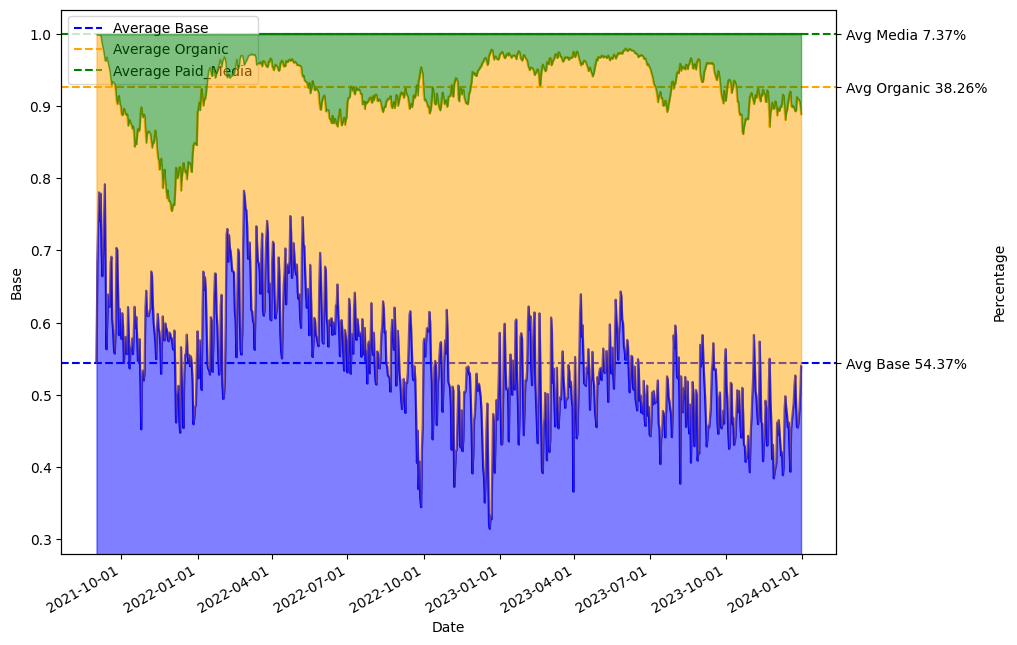

In [16]:

# Call the function with parameters
plot_area_chart(
    df_area_chart_percentages,
    'ds',
    'Base',
    'Organic',
    'Paid_Media',
    title="",
    fig_label="",
    save_dir=""
)


## Area Chart 4 Categories

### Coumputing the percentages of the columns for the area chart

In [ ]:

# Calculate the sum of values for each category and add as new columns
pareto_decomp_df['Base'] = pareto_decomp_df[base_cols].sum(axis=1)
pareto_decomp_df['Organic'] = pareto_decomp_df[organic_cols].sum(axis=1)
pareto_decomp_df['Paid_Media'] = pareto_decomp_df[paid_media_cols].sum(axis=1)
pareto_decomp_df['Paid_Media_effect_on_Organic'] = pareto_decomp_df[Paid_Media_effect_on_Organic].sum(axis=1)

# Create a new DataFrame with only the necessary columns and reset the index
area_chart_df = pareto_decomp_df[
    ['ds', 'Base', 'Organic', 'Paid_Media', 'Paid_Media_effect_on_Organic']
].reset_index(drop=True)

# Create a copy of the DataFrame for further manipulation
df = area_chart_df.copy()

# Define columns for the stacked area chart
column1 = 'Base'
column2 = 'Organic'
column3 = 'Paid_Media'
column4 = 'Paid_Media_effect_on_Organic'

# Set 'ds' as the index after converting it to datetime format
# Uncomment and modify the date format if needed
# df['ds'] = pd.to_datetime(df['ds'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
df.set_index('ds', inplace=True)

# Normalize the data by dividing each value by the sum of values in its row
df_area_chart_percentages = df.div(df.sum(axis=1), axis=0)

# Reset the index to include 'ds' as a column in the DataFrame
df_area_chart_percentages = df_area_chart_percentages.reset_index()

# Print the DataFrame to verify the result (optional)
df_area_chart_percentages


### Preparing the Area chart function

This funtion plots the percentage of base, organic and paid media orders also displays average percentage for base, organic, paid media and paid media effect on organic on the right side y-axis with a dotted horizontal line and finally prints the avg percentage values for base, organic, paid media and paid media effect on organic directly on the right side y-axis to complete the area chart.

In [ ]:

def plot_area_chart(
    df, ds, base, organic, paid_media, paid_media_effect_on_organic, title="", fig_label="", save_dir=""
):
    """
    Plot pct of base, organic, paid media, and paid media effect on organic.
    Displays average pct for base, organic, paid media, and paid media effect on organic on the right side y-axis 
    with a dotted horizontal line, and prints the avg pct values directly on the right side y-axis.

    Params:
        df: DataFrame - The data frame to plot.
        ds: str - Column for dates.
        base: str - Column for pct orders from base.
        organic: str - Column for pct orders from organic.
        paid_media: str - Column for pct orders from paid media.
        paid_media_effect_on_organic: str - Column for pct orders from paid organic.
        title: str - Title for the plot.
        fig_label: str - Label/name for the plot.
        save_dir: str - Path to save the plot.
    """
    assert all(c in df.columns for c in [ds, base, organic, paid_media, paid_media_effect_on_organic])

    # Ensure ds is a datetime column
    df[ds] = pd.to_datetime(df[ds])
    df = df.rename({ds: 'Date'}, axis=1)
    ds = 'Date'
    df_plot = df.copy()

    # Sort df_plot by ds to ensure the dates are in order
    df_plot.sort_values(by=ds, inplace=True)

    # Combine columns to calculate cumulative percentages
    df_plot["pct_base_organic"] = df_plot[base] + df_plot[organic]
    df_plot["pct_base_organic_media"] = df_plot["pct_base_organic"] + df_plot[paid_media]
    df_plot["all"] = df_plot["pct_base_organic_media"] + df_plot[paid_media_effect_on_organic]
    df_plot["all"] = np.where(df_plot["all"] > 1.0, 1.0, df_plot["all"])

    # Calculate averages
    avg_base = df_plot[base].mean()
    avg_organic = df_plot[organic].mean()
    avg_paid_media = df_plot[paid_media].mean()
    avg_paid_media_organic_interaction = df_plot[paid_media_effect_on_organic].mean()

    avg_organic_line = df_plot["pct_base_organic"].mean()
    avg_media_line = df_plot["pct_base_organic_media"].mean()
    avg_other_line = df_plot["all"].mean()

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    ax2 = axs.twinx()  # Create a second y-axis to display the average values

    # Plot the data
    sns.lineplot(data=df_plot, x=ds, y=base, color="blue", ax=axs)
    sns.lineplot(data=df_plot, x=ds, y="pct_base_organic", color="orange", ax=axs)
    sns.lineplot(data=df_plot, x=ds, y="pct_base_organic_media", color="green", ax=axs)
    sns.lineplot(data=df_plot, x=ds, y="all", color="red", ax=axs)

    # Adding horizontal lines for averages on the main y-axis
    axs.axhline(y=avg_base, color="blue", linestyle="--", label=f"Average {base}")
    axs.axhline(y=avg_organic_line, color="orange", linestyle="--", label="Average Organic")
    axs.axhline(y=avg_media_line, color="green", linestyle="--", label="Average Paid Media")
    axs.axhline(y=avg_other_line, color="red", linestyle="--", label="Average Paid Media effect on Organic")

    # Format x-axis to display dates correctly
    axs.xaxis.set_major_locator(mdates.AutoDateLocator())
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    plt.xticks(rotation=0)
    fig.autofmt_xdate()  # Auto format date labels for readability

    # Fill between the lines to show the stacked contributions
    plt.fill_between(df_plot[ds], df_plot[base], df_plot["pct_base_organic"], color="orange", alpha=0.5)
    plt.fill_between(df_plot[ds], df_plot["pct_base_organic"], df_plot["pct_base_organic_media"], color="green", alpha=0.5)
    plt.fill_between(df_plot[ds], df_plot["pct_base_organic_media"], df_plot["all"], color="red", alpha=0.5)
    plt.fill_between(df_plot[ds], 0, df_plot[base], color="blue", alpha=0.5)

    # Setting the average values on the right y-axis
    ax2.set_yticks([avg_base, avg_organic_line, avg_media_line, avg_other_line])
    ax2.set_yticklabels([
        f"Avg Base {avg_base:.2%}", 
        f"Avg Organic {avg_organic:.2%}", 
        f"Avg Paid Media {avg_paid_media:.2%}", 
        f"Avg Paid Media effect on Organic {avg_paid_media_organic_interaction:.2%}"
    ])
    ax2.set_ylim(axs.get_ylim())  # Ensure the right y-axis aligns with the left y-axis
    plt.xlabel('Date')
    plt.ylabel('Percentage')

    axs.legend(loc="upper left")
    axs.set_title(title, fontsize=16, fontdict={"weight": "normal"}, loc="left")

    # Save the plot if a directory is specified
    if save_dir:
        plt.savefig(f"{save_dir}/{fig_label}.png", bbox_inches="tight", transparent=False)
        plt.close()


### Plotting the area chart

In [ ]:

# Call the function with parameters
plot_area_chart(
    df_area_chart_percentages,
    'ds',
    'Base',
    'Organic',
    'Paid_Media',
    'Paid_Media_effect_on_Organic',
    title="",
    fig_label="",
    save_dir=""
)


## Area Chart 5 Categories

### Coumputing the percentages of the columns for the area chart

In [ ]:
# Calculate the sum of values for each category and add as new columns
pareto_decomp_df['Base'] = pareto_decomp_df[base_cols].sum(axis=1)
pareto_decomp_df['Organic'] = pareto_decomp_df[organic_cols].sum(axis=1)
pareto_decomp_df['Paid_Media'] = pareto_decomp_df[paid_media_cols].sum(axis=1)
pareto_decomp_df['Paid_Media_effect_on_Organic'] = pareto_decomp_df[Paid_Media_effect_on_Organic].sum(axis=1)
pareto_decomp_df['Paid_Media_effect_on_Base'] = pareto_decomp_df[Paid_Media_effect_on_Base].sum(axis=1)

# Create a new DataFrame with the necessary columns for visualization
area_chart_df = pareto_decomp_df[
    ['ds', 'Base', 'Organic', 'Paid_Media', 'Paid_Media_effect_on_Organic', 'Paid_Media_effect_on_Base']
].reset_index(drop=True)

# Create a copy of the DataFrame for further manipulation
df = area_chart_df.copy()

# Define the columns to be used in the stacked area chart
column1 = 'Base'
column2 = 'Organic'
column3 = 'Paid_Media'
column4 = 'Paid_Media_effect_on_Organic'
column5 = 'Paid_Media_effect_on_Base'

# Convert 'ds' (date) column to datetime format and set it as the DataFrame index
# Uncomment and modify the date format if necessary
# df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
df.set_index('ds', inplace=True)

# Normalize the data to get percentages for each row (for the stacked area chart)
# This divides each value by the sum of values in the same row
df_area_chart_percentages = df.div(df.sum(axis=1), axis=0)

# Reset the index to include 'ds' as a column again in the DataFrame
df_area_chart_percentages = df_area_chart_percentages.reset_index()

df_area_chart_percentages

### Preparing the Area chart function

This funtion plots the percentage of base, organic, paid media, paid media effect on organic and paid media effect on base also displays average percentage for base, organic, paid media, paid media effect on organic and paid media effect on base on the right side y-axis with a dotted horizontal line and finally prints the avg percentage values for base, organic, paid media, paid media effect on organic and paid media effect on base on organic directly on the right side y-axis to complete the area chart.

In [ ]:

def plot_area_chart(
    df, ds, base, organic, paid_media, 
    paid_media_effect_on_organic, paid_media_effect_on_base, 
    title="", fig_label="", save_dir=""
):
    """
    Plot pct of base, organic, paid media, paid media effect on organic and paid media effect on base orders.
    Displays average pct for base, organic, paid media, paid media effect on organic and paid media effect on base 
    on the right side y-axis with a dotted horizontal line, and prints the avg pct values 
    directly on the right side y-axis.

    Params:
        df: DataFrame - The data frame to plot.
        ds: str - Column for dates.
        base: str - Column for pct orders from base.
        organic: str - Column for pct orders from organic.
        paid_media: str - Column for pct orders from paid media.
        paid_media_effect_on_organic: str - Column for pct orders from paid organic.
        paid_media_effect_on_base: str - Column for pct orders from paid base.
        title: str - Title for the plot.
        fig_label: str - Label/name for the plot.
        save_dir: str - Path to save the plot.
    """
    # Ensure all required columns are in the dataframe
    required_columns = [ds, base, organic, paid_media, paid_media_effect_on_organic, paid_media_effect_on_base]
    assert all(col in df.columns for col in required_columns)

    # Ensure ds is a datetime column
    df[ds] = pd.to_datetime(df[ds])
    df = df.rename({ds: 'Date'}, axis=1)
    ds = 'Date'
    
    df_plot = df.copy()
    
    # Sort dataframe by date
    df_plot.sort_values(by=ds, inplace=True)
    
    # Combine columns to calculate cumulative percentages
    df_plot["pct_base_organic"] = df_plot[base] + df_plot[organic]
    df_plot["pct_base_organic_media"] = df_plot["pct_base_organic"] + df_plot[paid_media]
    df_plot["pct_base_organic_media_organic_interaction"] = df_plot["pct_base_organic_media"] + df_plot[paid_media_effect_on_organic]
    df_plot["all"] = df_plot["pct_base_organic_media_organic_interaction"] + df_plot[paid_media_effect_on_base]
    df_plot["all"] = np.where(df_plot["all"] > 1.0, 1.0, df_plot["all"])
    
    # Calculate averages
    avg_base = df_plot[base].mean()
    avg_organic = df_plot[organic].mean()
    avg_paid_media = df_plot[paid_media].mean()
    avg_paid_media_organic_interaction = df_plot[paid_media_effect_on_organic].mean()
    avg_paid_media_base_interaction = df_plot[paid_media_effect_on_base].mean()
    
    avg_organic_line = df_plot["pct_base_organic"].mean()
    avg_media_line = df_plot["pct_base_organic_media"].mean()
    avg_organic_interaction_line = df_plot["pct_base_organic_media_organic_interaction"].mean()
    avg_other_line = df_plot["all"].mean()
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    ax2 = axs.twinx()  # Create a second y-axis to display the average values
    
    # Plot the data
    sns.lineplot(data=df_plot, x=ds, y=base, color="blue", ax=axs)
    sns.lineplot(data=df_plot, x=ds, y="pct_base_organic", color="orange", ax=axs)
    sns.lineplot(data=df_plot, x=ds, y="pct_base_organic_media", color="green", ax=axs)
    sns.lineplot(data=df_plot, x=ds, y="pct_base_organic_media_organic_interaction", color="red", ax=axs)
    sns.lineplot(data=df_plot, x=ds, y="all", color="purple", ax=axs)
    
    # Adding horizontal lines for averages on the main y-axis
    axs.axhline(y=avg_base, color="blue", linestyle="--", label=f"Average {base}")
    axs.axhline(y=avg_organic_line, color="orange", linestyle="--", label="Average Organic")
    axs.axhline(y=avg_media_line, color="green", linestyle="--", label="Average Paid Media")
    axs.axhline(y=avg_organic_interaction_line, color="red", linestyle="--", label="Average Paid Media effect on Organic")
    axs.axhline(y=avg_other_line, color="purple", linestyle="--", label="Average Paid Media effect on Base")
    
    # Format x-axis to display dates correctly
    axs.xaxis.set_major_locator(mdates.AutoDateLocator())
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=0)
    fig.autofmt_xdate()  # Auto format date labels for readability
    
    # Fill between the lines to show the stacked contributions
    plt.fill_between(df_plot[ds], 0, df_plot[base], color="blue", alpha=0.5)
    plt.fill_between(df_plot[ds], df_plot[base], df_plot["pct_base_organic"], color="orange", alpha=0.5)
    plt.fill_between(df_plot[ds], df_plot["pct_base_organic"], df_plot["pct_base_organic_media"], color="green", alpha=0.5)
    plt.fill_between(df_plot[ds], df_plot["pct_base_organic_media"], df_plot["pct_base_organic_media_organic_interaction"], color="red", alpha=0.5)
    plt.fill_between(df_plot[ds], df_plot["pct_base_organic_media_organic_interaction"], df_plot["all"], color="purple", alpha=0.5)
    
    # Setting the average values on the right y-axis
    ax2.set_yticks([
        avg_base, 
        avg_organic_line, 
        avg_media_line, 
        avg_organic_interaction_line, 
        avg_other_line
    ])
    ax2.set_yticklabels([
        f"Avg Base {avg_base:.2%}", 
        f"Avg Organic {avg_organic:.2%}", 
        f"Avg Paid Media {avg_paid_media:.2%}", 
        f"Avg Paid Media effect on Organic {avg_paid_media_organic_interaction:.2%}", 
        f"Avg Paid Media effect on Base {avg_paid_media_base_interaction:.2%}"
    ])
    ax2.set_ylim(axs.get_ylim())  # Ensure the right y-axis aligns with the left y-axis
    
    plt.xlabel('Date')
    plt.ylabel('Percentage')
    axs.legend(loc="upper left")
    axs.set_title(title, fontsize=16, fontdict={"weight": "normal"}, loc="left")
    
    if save_dir:
        plt.savefig(save_dir, bbox_inches='tight')
    else:
        plt.show()


### Plotting the area chart

In [ ]:

# Call the function with parameters
plot_area_chart(
    df_area_chart_percentages,
    'ds',
    'Base',
    'Organic',
    'Paid_Media',
    'Paid_Media_effect_on_Organic',
    'Paid_Media_effect_on_Base',
    title="",
    fig_label="",
    save_dir=""
)


## Actual vs Predicted Charts

#### The trend_chart function plots time series trends for specified columns in a DataFrame, scaling the values to millions for clearer visualization. It handles missing dates by creating a full date range and fills any gaps with zero values. The resulting chart includes custom colors, labels, and a legend for easy interpretation.

In [ ]:
def millions_formatter(x, pos):
    """Formatter function to convert values into millions."""
    return f'{x / 1e6:.0f}'

def thousands_formatter(x, pos):
    """Formatter function to convert values into thousands."""
    return f'{x / 1e3:,.0f}'

def trend_chart(df_, cols, chart_title, date_var):
    """
    Plots trend chart for the specified columns.

    Params:
        df_: DataFrame - The data frame containing the data.
        cols: list - List of column names to plot.
        chart_title: list - List of titles corresponding to each column.
        date_var: str - The date column to plot on the x-axis.
    """
    
    # Convert 'Date' column to datetime format
    df_['Date'] = pd.to_datetime(df_['Date'])
    df_ = df_.sort_values(by='Date')
    
    # Create date range and merge with the original data
    min_date = df_[date_var].min()
    max_date = df_[date_var].max()
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    df_temp_flag = pd.DataFrame({'Date': date_range})
    df_ = pd.merge(df_, df_temp_flag, on='Date', how='outer')

    # Create a new DataFrame for scaled values
    df_scaled = pd.DataFrame()
    df_scaled['Date'] = df_['Date']
    
    # Fill missing values with 0 and scale values
    for var in cols:
        df_[var] = df_[var].fillna(0)
        df_scaled[var] = df_[var] / 1e6

    # Plotting
    plt.figure(figsize=(12, 3))  # Adjust figure size for better visibility
    
    colors = ['#ff5c8d', '#4280BA']  # Define colors for the lines
    
    for idx, var in enumerate(cols):
        sns.lineplot(
            data=df_scaled, 
            x='Date', 
            y=var, 
            label=chart_title[idx], 
            ci=None, 
            color=colors[idx]
        )
    
    # Add title and labels
    plt.title('Trends')
    plt.xlabel(date_var)
    plt.ylabel("In Millions")
    
    # Display legend and show plot
    plt.legend()
    plt.grid(False)
    plt.show()

#### Plotting trend chart for the specified columns

In [ ]:
# Columns to plot
columns_to_plot = [
    'dep_var', 
    'depVarHat'
]
## Uncomment the necessary names based on the target variable considered
chart_titles = [
    'Overall Visits', #Total App installs, #Overall Web Visits 
    'Predicted Overall Visits' #Predicted Total App installs #Predicted Overall Web Visits 
]

date_column = 'Date'

# Plot the trend chart
trend_chart(df_target, columns_to_plot, chart_titles, date_column)
